In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sns.set_context('talk')

In [2]:
nao_file = '../data/nao_station_monthly.txt'
slp_file = '../data/slp.mon.mean.nc'

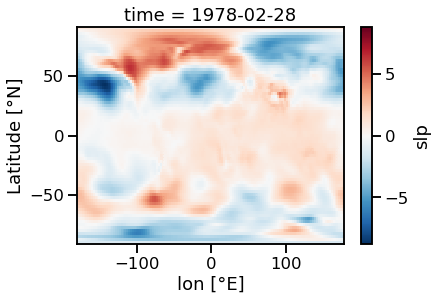

In [27]:
slp = xr.open_dataset(slp_file)

slp['lon'] = (((slp.lon + 180) % 360) - 180)
slp = slp.sortby('lon')
slp.lon.attrs['units'] = '°E'
slp.lat.attrs['units'] = '°N'

slp_DJF = (
    slp.resample(time='Q-FEB', label='right').mean('time')
)
slp_DJF = slp_DJF.where(slp_DJF['time.season'] == 'DJF', drop=True)
slp_DJF = slp_DJF - slp_DJF.mean('time')

slp_DJF.slp.isel(time=30).plot();

In [28]:
nao = np.loadtxt(nao_file, skiprows=2)

# year of the JAN value
nao_years = nao[:-1, 0] + 1
nao = nao[:, 1:].flatten()
nao_DJF = (nao[11:-1:12] + nao[12::12] + nao[13::12]) / 3.

nao = xr.DataArray(nao_DJF, dims={'time': len(nao_years)}, coords={'time': nao_years})

nao_lp = nao.rolling(time=11, center=True).mean().dropna(dim='time')

nao = (
    (nao - nao_lp)
    .where(
        (nao.time >= slp['time.year'].min())
        & (nao.time <= slp['time.year'].max())
    )
).dropna(dim='time')

In [29]:
nao_norm = (nao - nao.mean()) / nao.std()

nao_plus = (nao_norm >= 1)
nao_minus = (nao_norm <= -1)

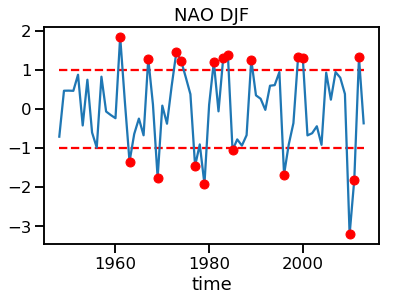

In [37]:
nao_norm.plot();

nao_norm.isel(time=nao_plus.values).plot(marker='o', linestyle='', color='r')
nao_norm.isel(time=nao_minus.values).plot(marker='o', linestyle='', color='r')

plt.hlines(
    xmin=nao_norm.time.min(), xmax=nao_norm.time.max(), y=(-1, 1),
    color='r', linestyle='--'
);
plt.title("NAO DJF");
plt.savefig('../img/3_composite_NAO_DJF.svg', bbox_inches='tight', pad_inches=.1)

In [31]:
slp_DJF = slp_DJF.where((slp_DJF['time.year'] >= nao.time.min()) & (slp_DJF['time.year'] <= nao.time.max())).dropna(dim='time')

In [32]:
slp_plus = slp_DJF.isel(time=nao_plus.values)
slp_minus = slp_DJF.isel(time=nao_minus.values)
slp_diff = slp_plus.slp.mean('time') - slp_minus.slp.mean('time')

In [33]:
# permutation test
np.random.seed(0)
n_rep = 10000

n1 = slp_plus.slp.shape[0]
n2 = slp_minus.slp.shape[0]

slp_combined = np.concatenate((slp_plus.slp.values, slp_minus.slp.values))
p_value = np.zeros(slp_plus.slp.shape[1:])

for i in range(n_rep):
    permutation = np.random.permutation(slp_combined)
    diff = permutation[:n1].mean(axis=0) - permutation[n1:].mean(axis=0)
    p_value += (np.abs(slp_diff) <= np.abs(diff)).astype(np.int)

p_value /= n_rep

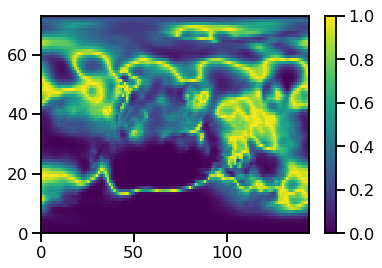

In [34]:
plt.pcolormesh(p_value)
plt.colorbar();

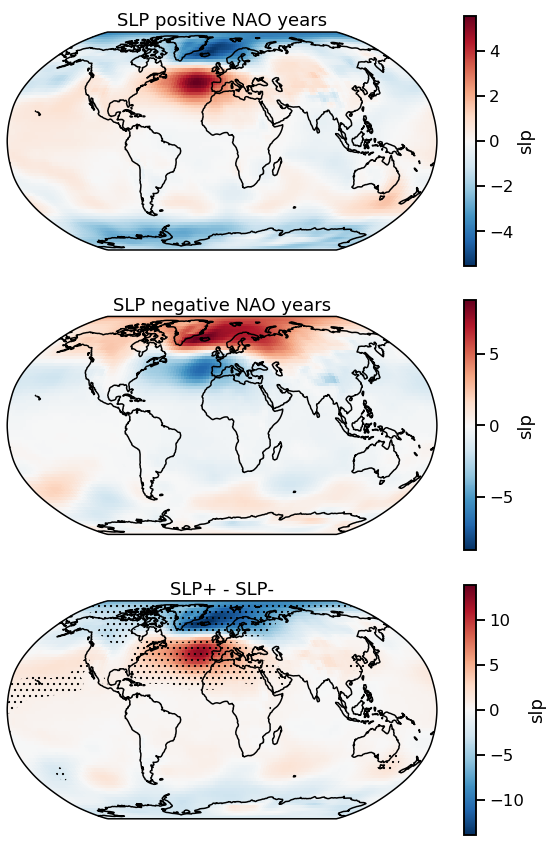

In [38]:
plt.figure(figsize=(8, 12))
map_proj = ccrs.Robinson(central_longitude=0)


ax1 = plt.subplot(3, 1, 1, projection=map_proj)
slp_plus.slp.mean('time').plot(ax=ax1, transform=ccrs.PlateCarree(), rasterized=True)
ax1.coastlines()
plt.title("SLP positive NAO years")

ax2 = plt.subplot(3, 1, 2, projection=map_proj)
slp_minus.slp.mean('time').plot(ax=ax2, transform=ccrs.PlateCarree(), rasterized=True)
ax2.coastlines();
plt.title("SLP negative NAO years")

ax3 = plt.subplot(3, 1, 3, projection=map_proj)
slp_diff.plot(
    ax=ax3, transform=ccrs.PlateCarree(), rasterized=True
)
ax3.contourf(
    slp_diff.lon, slp_diff.lat, p_value,
    levels=[0, .05, 1], colors='None', hatches=['..', None],
    transform=ccrs.PlateCarree()
)
ax3.coastlines()
plt.title('SLP+ - SLP-')

plt.tight_layout();
plt.savefig('../img/3_composite_SLP_DJF.svg', bbox_inches='tight', pad_inches=.1)